In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [13]:
returns=pd.read_csv('price_panel.csv',index_col=0,parse_dates=True).pct_change()
returns=returns.iloc[1:].copy()
returns.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3213 entries, 2008-12-02 to 2021-11-30
Columns: 1205 entries, 014160 to 006375
dtypes: float64(1205)
memory usage: 29.6 MB


### Winsorize
pca는 outlier에 취약하기 때문에 각각 끝 0.025씩 잘라내자

In [14]:
returns=returns.clip(lower=returns.quantile(q=0.025),
                    upper=returns.quantile(q=0.975),
                    axis=1)

#### missing value를 처리하자

1. 95%의 기간동안 데이터를 가지고 있지 않은 주식을 제거

2. 95%기간 동안 관측치를 가지고 있지 않은 거래일을 제거

In [16]:
returns=returns.dropna(thresh=int(returns.shape[0]*0.95),axis=1)
returns=returns.dropna(thresh=int(returns.shape[1]*0.95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3213 entries, 2008-12-02 to 2021-11-30
Columns: 956 entries, 014160 to 006375
dtypes: float64(956)
memory usage: 23.5 MB


In [19]:
daily_avg=returns.mean(axis=1)
returns = returns.apply(lambda x: x.fillna(daily_avg))

### PCA 알고리즘으로 팩터들을 봐보자

In [20]:
cov=np.cov(returns,rowvar=False)
pca=PCA(n_components='mle')
pca.fit(returns)

PCA(n_components='mle')

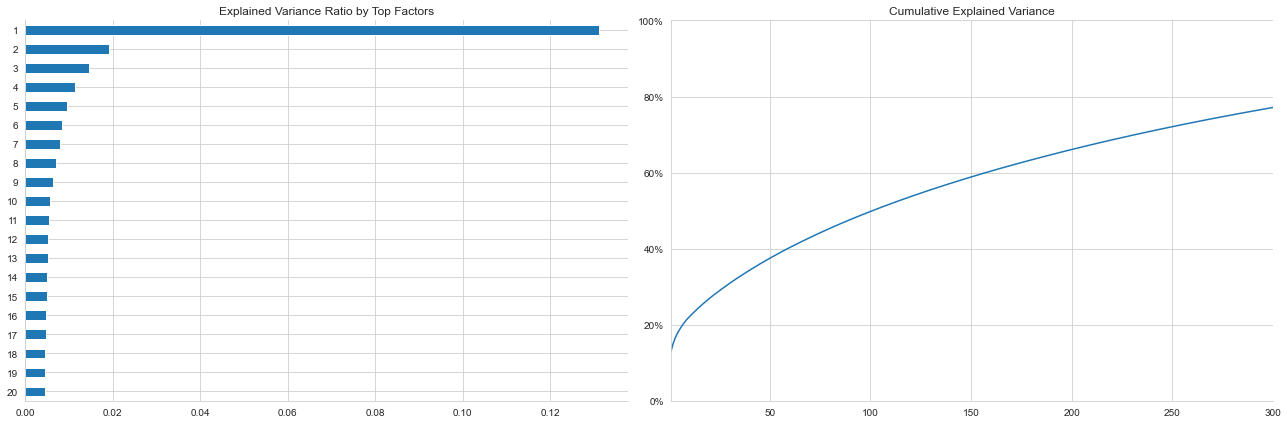

In [25]:
fig,axes=plt.subplots(ncols=2,figsize=(18,6))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:20].sort_values().plot.barh(title=title,ax=axes[0])
var_expl.cumsum().plot(ylim=(0,1),ax=axes[1],
                        title='Cumulative Explained Variance',
                        xlim=(1,300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [26]:
risk_factors = pd.DataFrame(pca.transform(returns)[:, :3], 
                            columns=['Principal Component 1', 'Principal Component 2','Principal Component 3'], 
                            index=returns.index)
risk_factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3213 entries, 2008-12-02 to 2021-11-30
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Principal Component 1  3213 non-null   float64
 1   Principal Component 2  3213 non-null   float64
 2   Principal Component 3  3213 non-null   float64
dtypes: float64(3)
memory usage: 100.4 KB


각각의 요소는 상관되어있지 않다

In [28]:
print(risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2']))
print(risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 3']))
print(risk_factors['Principal Component 2'].corr(risk_factors['Principal Component 3']))

4.246192918770256e-15
7.560117957792066e-16
-4.770693579558515e-16


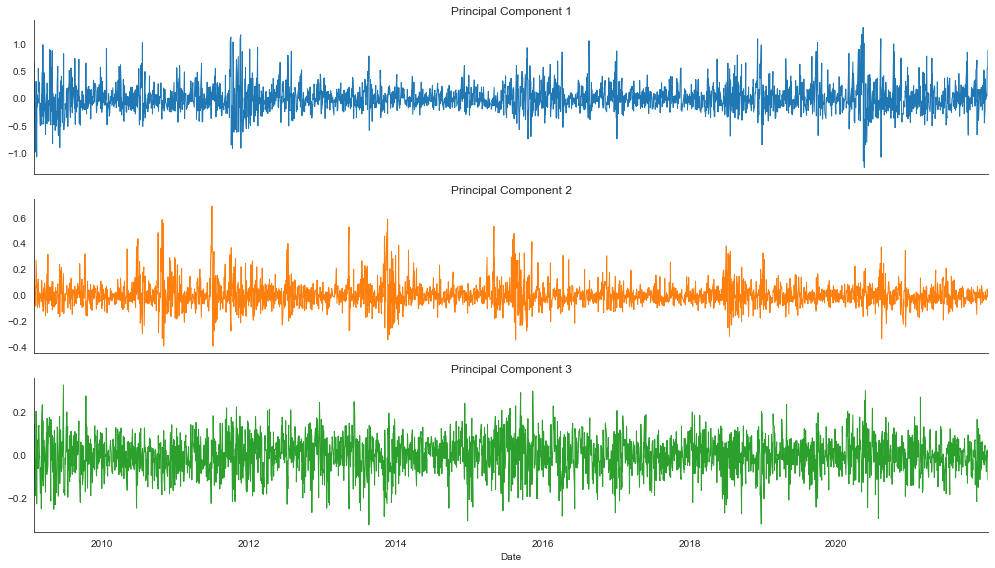

In [29]:
with sns.axes_style('white'):
    risk_factors.plot(subplots=True,
                      figsize=(14, 8),
                      title=risk_factors.columns.tolist(),
                      legend=False,
                      rot=0,
                      lw=1,
                      xlim=(risk_factors.index.min(),
                            risk_factors.index.max()))

    sns.despine()
    plt.tight_layout()

### eigen portfolio

In [39]:
returns=pd.read_csv('price_panel.csv',index_col=0,parse_dates=True).pct_change()
returns=returns.iloc[1:].copy()
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3213 entries, 2008-12-02 to 2021-11-30
Columns: 1205 entries, 014160 to 006375
dtypes: float64(1205)
memory usage: 29.6 MB


수익률을 정규화하고 winsorize하자

In [40]:
from sklearn.preprocessing import scale
normed_returns = scale(returns
                       .clip(lower=returns.quantile(q=0.025), 
                             upper=returns.quantile(q=0.975), 
                             axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std())))

위에 처럼 결측치를 처리하자


In [41]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3213 entries, 2008-12-02 to 2021-11-30
Columns: 956 entries, 014160 to 006375
dtypes: float64(956)
memory usage: 23.5 MB


In [42]:
cov = returns.cov()



PCA 실행

In [44]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{}'.format)

,Explained Variance
0,0.999999999999985
1,6.613177234444831e-15
2,5.8024197286368596e-15
3,9.294486318286772e-16
4,3.628500646106904e-16


In [55]:
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]

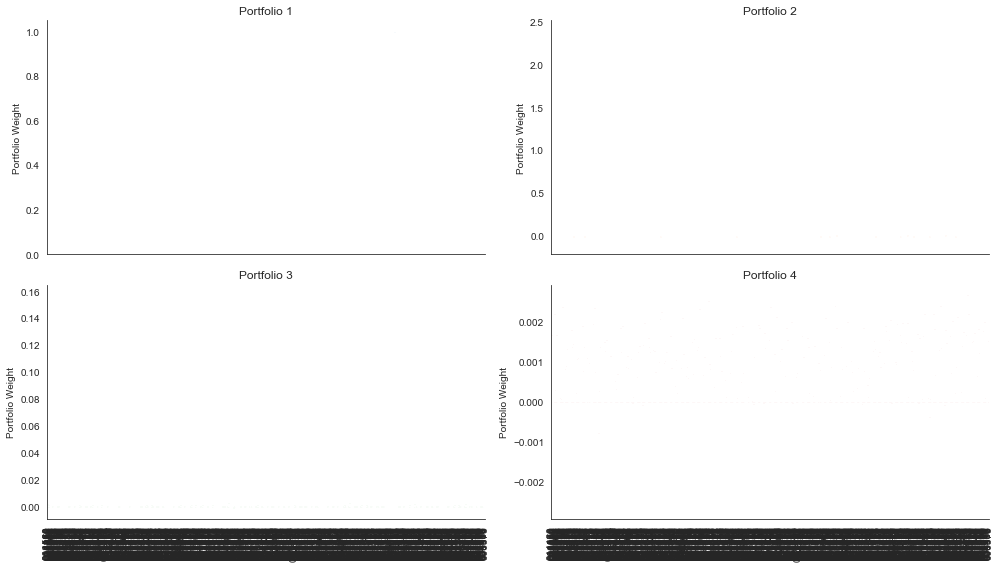

In [56]:
sns.set_style('white')
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(2, 2),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

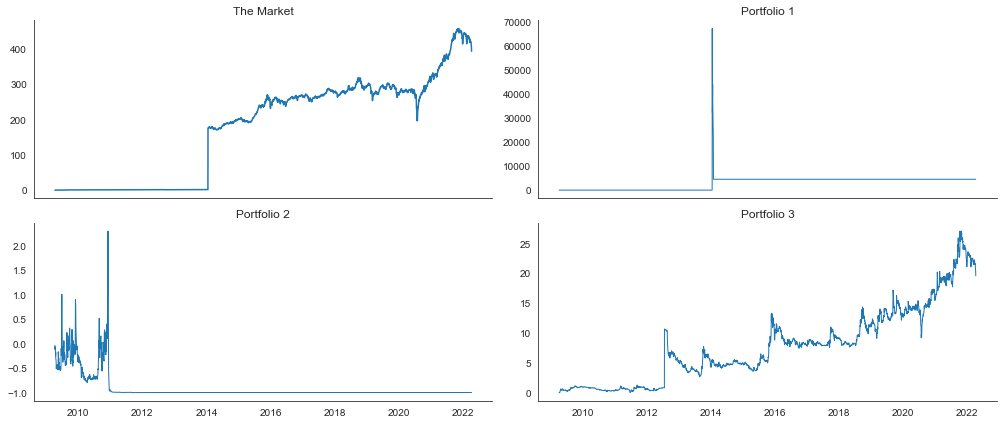

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(3):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(4):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()